## 4. Training

In this part of notebook we will try to train the model using feature extracted dataframe and make model evaluation

### Setup Prerequisite

In [1]:
!pip install pyspark

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Needed Library, Initialize Spark and Load Dataframe

In [62]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
import seaborn as sns

In [4]:
spark = SparkSession.builder.appName('sparkify-train').getOrCreate()

In [5]:
# load data and change is_churn column into label column

isOnColab = True # CHANGE THIS VARIABLE IF RUNNING ON DATAPROC

path = '/content/drive/MyDrive/datasets/dsnd-sparkify/ml_df.parquet' if isOnColab else 'gs://udacity-dsnd/ml_df.parquet'
df = spark.read.parquet(path)
df = df.withColumn('label', F.when(F.col("is_churn"), 1).otherwise(0))
df.show(5)

+-------+-------------------+--------+----------+-------------+------------------+----------+-----------+---------+------------------+----------+-----+------+-----+-----+-------+-------+------------+-------------+----------+------------+-----+
| userId|              up_ts|is_churn|song_count|subs_duration|         song_rate|n_playlist|thumbs_down|thumbs_up|      avg_sess_len|sess_count| ipad|iphone|linux|macos|windows|n_error|n_friend_add|n_cancel_page|n_unq_song|n_unq_artist|label|
+-------+-------------------+--------+----------+-------------+------------------+----------+-----------+---------+------------------+----------+-----+------+-----+-----+-------+-------+------------+-------------+----------+------------+-----+
|1071843|2018-11-08 13:16:59|   false|      1190|           22| 54.09090909090909|        39|          6|       51|27020.272727272728|        11|false| false|false| true|  false|      1|          32|            0|      1104|         902|    0|
|1120784|2018-10-11 14:1

### Vectorize Features and Select Only Needed Column

In [6]:
# features columns
feature_cols = df.columns[3:-1]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# take only features and label column
df = df.select(["features", "label"])

### Split Dataframe for Training and Testing

In [7]:
train_df, test_df = df.randomSplit([0.9,0.1], seed=42)

In [35]:
print("train")
train_df.groupby("label").count().show()

print("test")
test_df.groupby("label").count().show()

train
+-----+-----+
|label|count|
+-----+-----+
|    1| 4470|
|    0| 9148|
+-----+-----+

test
+-----+-----+
|label|count|
+-----+-----+
|    1|  480|
|    0| 1037|
+-----+-----+



We have around 1:2 ratio between 1 and 0 label. It shows that we have balanced train and test data split

### Build Grid Search, Train Model and Predict Test Data

In [10]:
# gradient boosted tree algorithm
gbt = GBTClassifier()

# Grid search parameter
gbt_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [4, 5, 6]) \
    .addGrid(gbt.maxIter, [15, 20, 25]) \
    .build()

# train validation split to search through all grid
gbt_tvs = TrainValidationSplit(estimator=gbt,
                            estimatorParamMaps=gbt_grid,
                            evaluator=BinaryClassificationEvaluator(),
                            trainRatio=0.75,
                            seed=42)

In [11]:
# train model
gbt_model = gbt_tvs.fit(train_df)

In [36]:
gbt_model.bestModel

GBTClassificationModel: uid = GBTClassifier_de3b32670a8c, numTrees=25, numClasses=2, numFeatures=18

In [14]:
gbt_model.bestModel.featureImportances

SparseVector(18, {0: 0.0001, 1: 0.3445, 2: 0.1394, 3: 0.0052, 4: 0.0234, 5: 0.0262, 6: 0.0928, 7: 0.1744, 8: 0.0003, 13: 0.0009, 14: 0.0033, 15: 0.1882, 16: 0.0013})

As seen above, the most important feature in gradient boost model are number 1 (subscription duration) with value 0.3445, number 2 (songs heard per day of subscription) with value 0.1394, number 7 (sessions count) with value 0.1744 and number 15 (cancel confirmation visit)

In [30]:
# predict on test dataframe
preds_df = gbt_model.transform(test_df)

### Evaluate model

In [40]:
def evaluate(df, label_col='label', pred_col='prediction'):
    '''
    INPUT:
    df - spark dataframe
    label_col - name of label column
    pred_col - name of prediction column

    OUTPUT:
    res - pandas dataframe of metrics
    '''

    temp_df = df.select([label_col, pred_col]).toPandas()
    
    return pd.DataFrame.from_dict({
        "accuracy" : [accuracy_score(temp_df[label_col], temp_df[pred_col])],
        "precision" : [precision_score(temp_df[label_col], temp_df[pred_col])],
        "recall" : [recall_score(temp_df[label_col], temp_df[pred_col])],
        "f1" : [f1_score(temp_df[label_col], temp_df[pred_col])],
        "roc_auc" : [roc_auc_score(temp_df[label_col], temp_df[pred_col])],
    })

In [44]:
# metrics result
evaluate(preds_df)

,accuracy,precision,recall,f1,roc_auc
0,0.78708,0.663202,0.664583,0.663892,0.754182


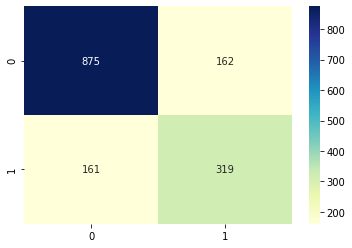

In [72]:
# confusion matrix
c_mat = confusion_matrix(preds_df.select("label").toPandas(),
                preds_df.select("prediction").toPandas())

ax = sns.heatmap(c_mat, annot=True, fmt="d", cmap="YlGnBu")

With metrics shown above, the result is good enough to make churn prediction

In [ ]:
model.save('/content/drive/MyDrive/datasets/dsnd-sparkify/sparkify_model')

In [47]:
train_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = false)



In [55]:
train1_df = train_df.withColumn("weight", F.when(F.col("label") == 1, 1).otherwise(0.5))

In [56]:
gbt1_tvs = TrainValidationSplit(estimator=gbt,
                            estimatorParamMaps=gbt_grid,
                            evaluator=BinaryClassificationEvaluator(weightCol='weight',),
                            trainRatio=0.75,
                            seed=42)

gbt1_model = gbt1_tvs.fit(train1_df)

In [57]:
preds1_df = gbt1_model.transform(test_df)

In [58]:
evaluate(preds1_df)

,accuracy,precision,recall,f1,roc_auc
0,0.78708,0.663202,0.664583,0.663892,0.754182


In [61]:
type(confusion_matrix(preds1_df.select("label").toPandas(),
                preds1_df.select("prediction").toPandas()))

numpy.ndarray